In [1]:
import copy
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import sys
import unyt

In [2]:
import analysis_config

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import palettable
%matplotlib inline

In [4]:
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [6]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.astro as astro_tools

In [7]:
import linefinder.utils.file_management as file_management_old
import linefinder.utils.file_management_new as file_management
import linefinder.config as config

# Load Data

### Parameters

In [8]:
# Sim params
default_sim = 'm12i'
default_snum = 600
resolution = 7100
physics = 'core'
subsubdir = None

In [9]:
# Halo file params
mt_kwargs = {
    'tag': 'smooth',
}

In [10]:
# Data selection params
t_window = 1. # In Gyr
galdef = ''
galaxy_cut = 0.1
length_scale = 'Rvir'

### Get Data Structures

In [11]:
if len( sys.argv ) == 2:
    sim_name = sys.argv[1]
else:
    sim_name = default_sim

In [12]:
# Automatically set or retrieve args
if len( sys.argv ) == 3:
    try:
        snum = int( sys.argv[2] )
    except ValueError:
        snum = default_snum
else:
    snum = default_snum

In [13]:
sim_kwargs = dict(
    sim_name = sim_name,
    resolution = resolution,
    physics = physics,
    subsubdir = subsubdir,
)

In [14]:
fm = file_management.FileManager( 'hot_accretion' )
fm_old = file_management_old.FileManager( 'hot_accretion' )

In [15]:
ind = 600 - snum

In [16]:
s_data = particle_data.ParticleData(
    sdir = fm.get_sim_dir( **sim_kwargs ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = fm.get_halo_dir( **sim_kwargs, halo_subdir='' ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

In [17]:
# Find characteristic length scale of the galaxy
r_half = s_data.halo_data.get_mt_data(
    'Rstar0.5',
    snums=[snum,],
    mt_halo_id=s_data.main_halo_id
)
r_vir = r_half = s_data.halo_data.get_mt_data(
    'Rvir',
    snums=[snum,],
    mt_halo_id=s_data.main_halo_id
)

# Truncation Radii

#### Kregel+2002

In [116]:
# In units of disk scale length
r_kregel2002_in_hr = 3.6
r_kregel2002_in_hr_std = 0.6

#### Relationships for Disk Scale Length

In [117]:
hr_kravtsov2013_in_rvir = 0.015
hr_kravtsov2013_converted_kpc = hr_kravtsov2013_in_rvir * s_data.r_vir

#### Martin-Navarro+2012

In [118]:
# In units of kpc
r_martinnavarro2012_kpc = 14.
r_martinnavarro2012_kpc_std = 2.

In [119]:
# "break" radius in units of kpc
r_break_martinnavarro2012_kpc = 8.
r_break_martinnavarro2012_kpc_std = 1.

In [120]:
# Stellar density at truncation/break
sigma_martinnavarro2012 = 1.
sigma_break_martinnavarro2012 = 10.**1.2

# Surface Density Profiles

### Rotate

In [121]:
# Get rotated coords

unrot_coords = s_data.get_data( 'P' ).transpose()

rot_ax = np.cross( s_data.total_ang_momentum/np.linalg.norm( s_data.total_ang_momentum ), np.array([0., 1., 0. ]) )
angle = np.arcsin( np.linalg.norm(rot_ax) )

coords = data_operations.rotate_coordinates( unrot_coords, angle, rot_ax )

In [122]:
edges = np.linspace( -0.5*r_vir, 0.5*r_vir, 2**11 )
dx = edges[1] - edges[0]
centers = edges[:-1] + 0.5 * dx

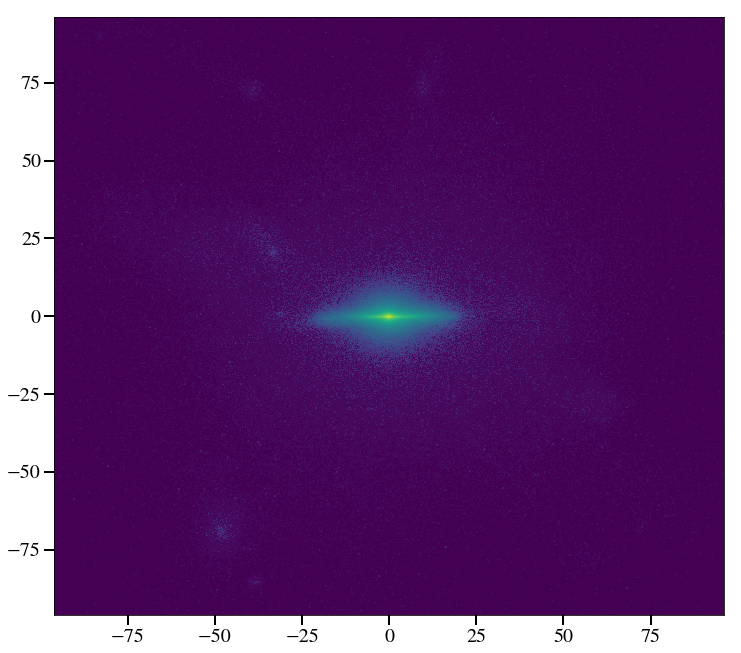

In [123]:
%matplotlib inline

fig = plt.figure( figsize=(12, 11), facecolor='w' )
ax = plt.gca()

hist, x_edges, y_edges, img = ax.hist2d(
    coords[:,0],
    coords[:,1],
    [ edges, edges ],
    weights = s_data.get_data( 'M' ) * 1e10,
    norm = matplotlib.colors.LogNorm(),
)

ax.set_facecolor( palettable.matplotlib.Viridis_14.mpl_colors[0] )

### Calculate Surface Density

In [124]:
xs, ys = np.meshgrid( centers, centers )
xs, ys = xs.flatten(), ys.flatten()

In [125]:
rs = np.sqrt( xs**2. + ys**2. )

In [126]:
surf_den = hist.flatten() / dx**2. * (unyt.Msun / unyt.kpc**2 )

### Calculate Surface Density

In [127]:
xs, ys = np.meshgrid( centers, centers )
xs, ys = xs.flatten(), ys.flatten()

In [128]:
rs = np.sqrt( xs**2. + ys**2. )

In [129]:
surf_den = hist.flatten() / dx**2. * (unyt.Msun / unyt.kpc**2 )

### Radial Stellar Profile

In [130]:
logr_edges = np.linspace( -1, 2, 128 )

In [131]:
logr_cents = logr_edges[1:] + 0.5*dx
r_cents = 10.**logr_cents

In [132]:
median, logr_edges, bin_num = scipy.stats.binned_statistic(
    np.log10( rs ),
    surf_den.to( 'Msun/pc**2'),
    bins = logr_edges,
    statistic = np.nanmedian,
)

mean, logr_edges, bin_num = scipy.stats.binned_statistic(
    np.log10( rs ),
    surf_den.to( 'Msun/pc**2'),
    bins = logr_edges,
    statistic = np.nanmean,
)

In [133]:
lower, logr_edges, bin_num = scipy.stats.binned_statistic(
    np.log10( rs ),
    surf_den.to( 'Msun/pc**2'),
    bins = logr_edges,
    statistic = lambda x: np.nanpercentile( x, 16. ),
)
upper, logr_edges, bin_num = scipy.stats.binned_statistic(
    np.log10( rs ),
    surf_den.to( 'Msun/pc**2'),
    bins = logr_edges,
    statistic = lambda x: np.nanpercentile( x, 84. ),
)

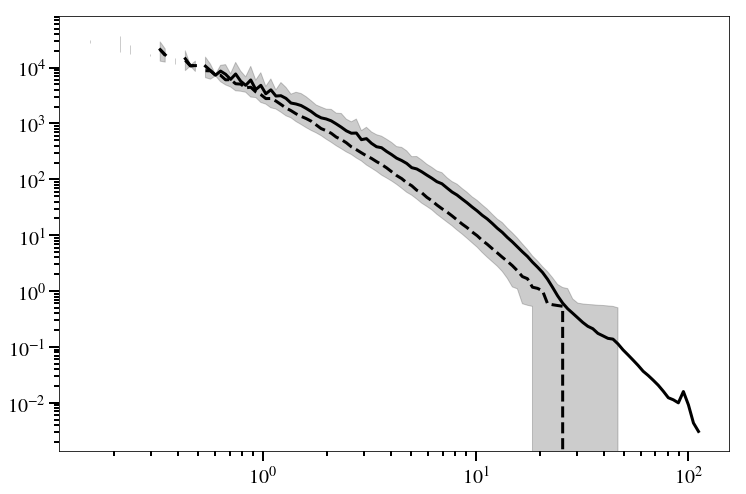

In [134]:

fig = plt.figure( figsize=(12, 8), facecolor='w' )
ax = plt.gca()

ax.plot(
    r_cents,
    median,
    linewidth = 3,
    color = 'k',
    linestyle = '--',
)

ax.plot(
    r_cents,
    mean,
    linewidth = 3,
    color = 'k',
)

ax.fill_between(
    r_cents,
    lower,
    upper,
    color = 'k',
    alpha = 0.2,
)

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

### Edge-On Stellar Stellar Mass Profile

In [135]:
# Approximate maximum scale-height from Gurvich+2020
h_max = 1.5
above_or_below = np.abs( ys ) < 5 * h_max
nonzero_surfden = surf_den.to( 'Msun/pc**2') > 0.
rough_used_xs = np.abs( xs[above_or_below] )
rough_surf_dens = surf_den.to( 'Msun/pc**2')[above_or_below]

In [136]:
used_x_edges = x_edges[int(len( x_edges )/2):]
used_x_cents = used_x_edges[1:] + 0.5*dx

In [137]:
logx_edges = np.linspace( -1, 2, 128 )

In [138]:
logx_cents = logx_edges[1:] + 0.5*dx
x_cents = 10.**logx_cents

In [139]:
median, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_surf_dens,
    bins = used_x_edges,
    statistic = np.nanmedian,
)

mean, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_surf_dens,
    bins = used_x_edges,
    statistic = np.nanmean,
)

In [140]:
lower, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_surf_dens,
    bins = used_x_edges,
    statistic = lambda x: np.nanpercentile( x, 16. ),
)
upper, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_surf_dens,
    bins = used_x_edges,
    statistic = lambda x: np.nanpercentile( x, 84. ),
)

#### Calculate the disk scale length

In [141]:
interp_fn = scipy.interpolate.interp1d( mean, used_x_cents )
hr = interp_fn( mean[0] / np.e )

In [142]:
colormap = palettable.cartocolors.qualitative.Safe_10.mpl_colors

Text(0, 0.5, '$\\Sigma_\\star$ ($M_\\odot/$pc$^2$)')

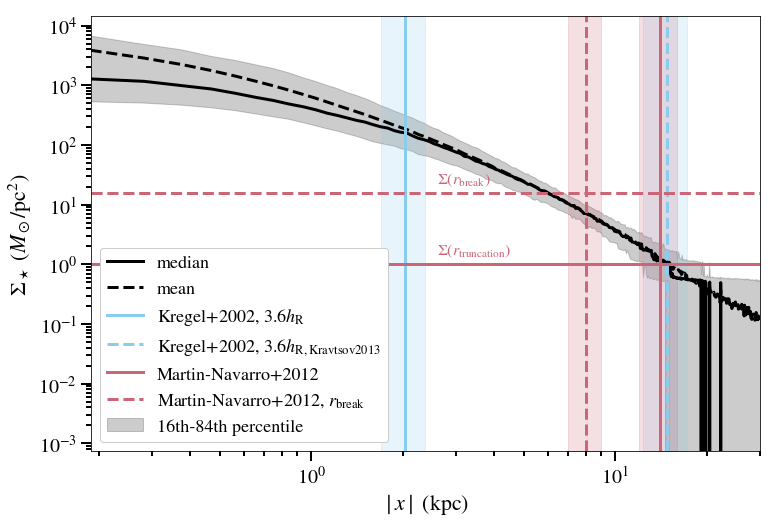

In [143]:

fig = plt.figure( figsize=(12, 8), facecolor='w' )
ax = plt.gca()

ax.plot(
    used_x_cents,
    median,
    linewidth = 3,
    color = 'k',
    linestyle = '-',
    label = 'median',
)

ax.plot(
    used_x_cents,
    mean,
    linewidth = 3,
    color = 'k',
    linestyle = '--',
    label = 'mean',
)

ax.fill_between(
    used_x_cents,
    lower,
    upper,
    color = 'k',
    alpha = 0.2,
    label = '16th-84th percentile',
)

# Kregel 2002
ax.axvline(
    r_kregel2002_in_hr * hr,
    color = colormap[0],
    linewidth = 3.,
    label = r'Kregel+2002, $3.6h_{\rm R}$'
)
ax.fill_betweenx(
    [ 0, 1 ],
    [ ( r_kregel2002_in_hr - r_kregel2002_in_hr_std ) * hr, ]*2,
    [ ( r_kregel2002_in_hr + r_kregel2002_in_hr_std ) * hr, ]*2,
    color = colormap[0],
    alpha = 0.2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
)
ax.axvline(
    r_kregel2002_in_hr * hr_kravtsov2013_converted_kpc,
    color = colormap[0],
    linewidth = 3.,
    linestyle = '--',
    label = r'Kregel+2002, $3.6h_{\rm R,Kravtsov2013}$'
)
ax.fill_betweenx(
    [ 0, 1 ],
    [ ( r_kregel2002_in_hr - r_kregel2002_in_hr_std ) * hr_kravtsov2013_converted_kpc, ]*2,
    [ ( r_kregel2002_in_hr + r_kregel2002_in_hr_std ) * hr_kravtsov2013_converted_kpc, ]*2,
    color = colormap[0],
    alpha = 0.2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
)

# Martin-Navarro 2012
ax.axvline(
    r_martinnavarro2012_kpc,
    color = colormap[1],
    linewidth = 3.,
    label = r'Martin-Navarro+2012'
)
ax.fill_betweenx(
    [ 0, 1 ],
    [ r_martinnavarro2012_kpc - r_martinnavarro2012_kpc_std ]*2,
    [ r_martinnavarro2012_kpc + r_martinnavarro2012_kpc_std ]*2,
    color = colormap[1],
    alpha = 0.2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
)
ax.axhline(
    sigma_martinnavarro2012,
    color = colormap[1],
    linewidth = 3.,
#     label = r'Martin-Navarro+2012, $\Sigma(r_{\rm truncation})$',
)
ax.annotate(
    s = r'$\Sigma(r_{\rm truncation})$',
    xy = ( 2.5, sigma_martinnavarro2012 ),
    xytext = ( 5, 5 ),
    xycoords = 'data',
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
    fontsize = 16,
    color = colormap[1],
)
ax.axvline(
    r_break_martinnavarro2012_kpc,
    color = colormap[1],
    linewidth = 3.,
    label = r'Martin-Navarro+2012, $r_{\rm break}$',
    linestyle = '--',
)
ax.fill_betweenx(
    [ 0, 1 ],
    [ r_break_martinnavarro2012_kpc - r_break_martinnavarro2012_kpc_std ]*2,
    [ r_break_martinnavarro2012_kpc + r_break_martinnavarro2012_kpc_std ]*2,
    color = colormap[1],
    alpha = 0.2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
)
ax.axhline(
    sigma_break_martinnavarro2012,
    color = colormap[1],
    linewidth = 3.,
    linestyle = '--',
#     label = r'Martin-Navarro+2012, $\Sigma(r_{\rm truncation})$',
)
ax.annotate(
    s = r'$\Sigma(r_{\rm break})$',
    xy = ( 2.5, sigma_break_martinnavarro2012 ),
    xytext = ( 5, 5 ),
    xycoords = 'data',
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
    fontsize = 16,
    color = colormap[1],
)

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

ax.set_xlim( used_x_cents[0], 30. )
# ax.set_ylim( 2e5, 1e10 )

l = ax.legend( prop={'size': 18, }, framealpha=1.0 )

ax.set_xlabel( r'$\mid x \mid$ (kpc)', fontsize=22 )
ax.set_ylabel( r'$\Sigma_\star$ ($M_\odot/$pc$^2$)', fontsize=22 )

In [144]:
used_xs = xs[above_or_below&nonzero_surfden]
used_surf_dens = surf_den.to( 'Msun/pc**2')[above_or_below&nonzero_surfden]

In [145]:
median, used_x_edges, bin_num = scipy.stats.binned_statistic(
    used_xs,
    used_surf_dens,
    bins = used_x_edges,
    statistic = np.nanmedian,
)

mean, used_x_edges, bin_num = scipy.stats.binned_statistic(
    used_xs,
    used_surf_dens,
    bins = used_x_edges,
    statistic = np.nanmean,
)

In [146]:
lower, used_x_edges, bin_num = scipy.stats.binned_statistic(
    used_xs,
    used_surf_dens,
    bins = used_x_edges,
    statistic = lambda x: np.nanpercentile( x, 16. ),
)
upper, used_x_edges, bin_num = scipy.stats.binned_statistic(
    used_xs,
    used_surf_dens,
    bins = used_x_edges,
    statistic = lambda x: np.nanpercentile( x, 84. ),
)

Text(0, 0.5, '$\\Sigma_\\star$ ($M_\\odot/$pc$^2$)')

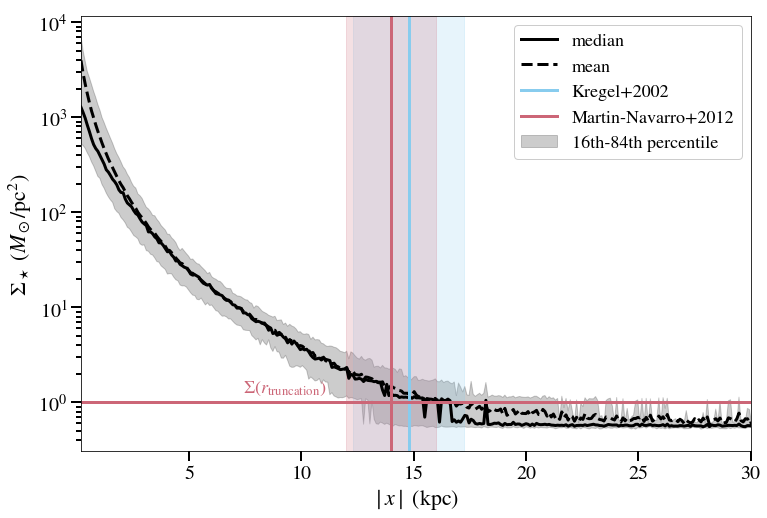

In [147]:

fig = plt.figure( figsize=(12, 8), facecolor='w' )
ax = plt.gca()

ax.plot(
    used_x_cents,
    median,
    linewidth = 3,
    color = 'k',
    linestyle = '-',
    label = 'median',
)

ax.plot(
    used_x_cents,
    mean,
    linewidth = 3,
    color = 'k',
    linestyle = '--',
    label = 'mean',
)

ax.fill_between(
    used_x_cents,
    lower,
    upper,
    color = 'k',
    alpha = 0.2,
    label = '16th-84th percentile',
)

# Kregel 2002
ax.axvline(
    r_kregel2002_in_hr * hr_kravtsov2013_converted_kpc,
    color = colormap[0],
    linewidth = 3.,
#     linestyle = '--',
    label = r'Kregel+2002'
)
ax.fill_betweenx(
    [ 0, 1 ],
    [ ( r_kregel2002_in_hr - r_kregel2002_in_hr_std ) * hr_kravtsov2013_converted_kpc, ]*2,
    [ ( r_kregel2002_in_hr + r_kregel2002_in_hr_std ) * hr_kravtsov2013_converted_kpc, ]*2,
    color = colormap[0],
    alpha = 0.2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
)

# Martin-Navarro 2012
ax.axvline(
    r_martinnavarro2012_kpc,
    color = colormap[1],
    linewidth = 3.,
    label = r'Martin-Navarro+2012'
)
ax.fill_betweenx(
    [ 0, 1 ],
    [ r_martinnavarro2012_kpc - r_martinnavarro2012_kpc_std ]*2,
    [ r_martinnavarro2012_kpc + r_martinnavarro2012_kpc_std ]*2,
    color = colormap[1],
    alpha = 0.2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
)
ax.axhline(
    sigma_martinnavarro2012,
    color = colormap[1],
    linewidth = 3.,
#     label = r'Martin-Navarro+2012, $\Sigma(r_{\rm truncation})$',
)
ax.annotate(
    s = r'$\Sigma(r_{\rm truncation})$',
    xy = ( r_martinnavarro2012_kpc - r_martinnavarro2012_kpc_std, sigma_martinnavarro2012 ),
    xytext = ( -20, 5 ),
    xycoords = 'data',
    textcoords = 'offset points',
    ha = 'right',
    va = 'bottom',
    fontsize = 18,
    color = colormap[1],
)

# ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

ax.set_xlim( used_x_cents[0], 30. )
# ax.set_ylim( 2e5, 1e10 )

l = ax.legend( prop={'size': 18, }, framealpha=1.0 )

ax.set_xlabel( r'$\mid x \mid$ (kpc)', fontsize=22 )
ax.set_ylabel( r'$\Sigma_\star$ ($M_\odot/$pc$^2$)', fontsize=22 )

# Brightness Profiles

### Calculate Luminosity

In [240]:
import luminosity_yu

In [241]:
import galaxy_dive.utils.astro as astro_utils

In [242]:
stellar_redshift = (1. / s_data.get_data( 'Age' ) - 1. )
stellar_age = (
    astro_utils.age_of_universe( 0., s_data.data_attrs['hubble'], s_data.data_attrs['omega_matter'] ) -
    astro_utils.age_of_universe( stellar_redshift, s_data.data_attrs['hubble'], s_data.data_attrs['omega_matter'] )
)

In [243]:
luminosity = luminosity_yu.get_attenuated_stellar_luminosities(
    BAND_IDS = [ 4, ],
    stellar_age = stellar_age,
    stellar_metallicity = s_data.get_data( 'Z' ),
    stellar_mass = s_data.get_data( 'M' ),
)

Calculating M/L in Sloan i (4,4)


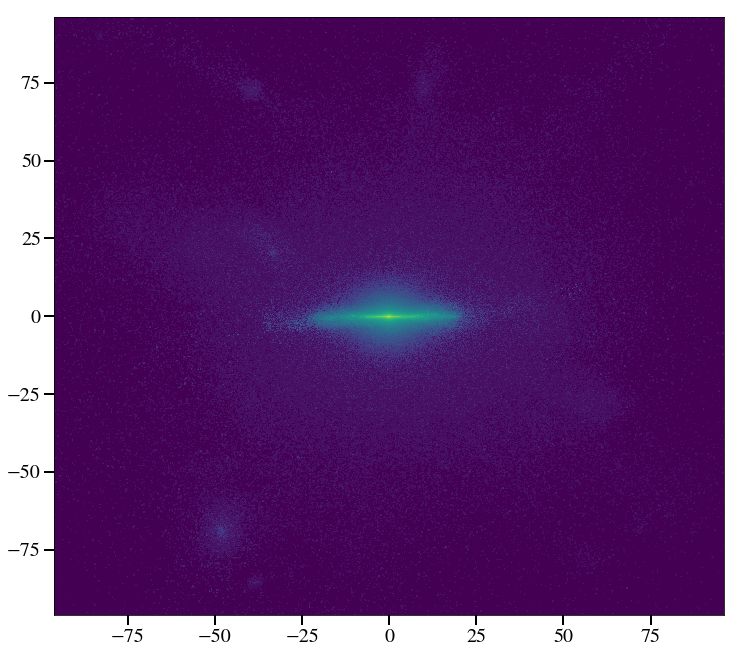

In [244]:
%matplotlib inline

fig = plt.figure( figsize=(12, 11), facecolor='w' )
ax = plt.gca()

hist, x_edges, y_edges, img = ax.hist2d(
    coords[:,0],
    coords[:,1],
    [ edges, edges ],
    weights = luminosity[0],
    norm = matplotlib.colors.LogNorm(),
)

ax.set_facecolor( palettable.matplotlib.Viridis_14.mpl_colors[0] )

### Calculate Brightness

In [245]:
xs, ys = np.meshgrid( centers, centers )
xs, ys = xs.flatten(), ys.flatten()

In [246]:
rs = np.sqrt( xs**2. + ys**2. )

In [247]:
brightness = hist.flatten() / dx**2. * (unyt.erg / unyt.s / unyt.kpc**2 )

### Edge-On Brightness Profile

In [248]:
# Approximate maximum scale-height from Gurvich+2020
h_max = 1.5
above_or_below = np.abs( ys ) < 5 * h_max
nonzero_brightness = brightness > 0.
rough_used_xs = np.abs( xs[above_or_below] )
rough_brightness = brightness[above_or_below]

In [249]:
used_x_edges = x_edges[int(len( x_edges )/2):]
used_x_cents = used_x_edges[1:] + 0.5*dx

In [250]:
logx_edges = np.linspace( -1, 2, 128 )

In [251]:
logx_cents = logx_edges[1:] + 0.5*dx
x_cents = 10.**logx_cents

In [252]:
median, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_brightness,
    bins = used_x_edges,
    statistic = np.nanmedian,
)

mean, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_brightness,
    bins = used_x_edges,
    statistic = np.nanmean,
)

In [253]:
lower, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_brightness,
    bins = used_x_edges,
    statistic = lambda x: np.nanpercentile( x, 16. ),
)
upper, used_x_edges, bin_num = scipy.stats.binned_statistic(
    rough_used_xs,
    rough_brightness,
    bins = used_x_edges,
    statistic = lambda x: np.nanpercentile( x, 84. ),
)

#### Calculate the disk scale length

In [254]:
interp_fn = scipy.interpolate.interp1d( mean, used_x_cents )
hr = interp_fn( mean[0] / np.e )

In [255]:
colormap = palettable.cartocolors.qualitative.Safe_10.mpl_colors

Text(0, 0.5, 'Brigthness (erg/s/kpc$^2$?)')

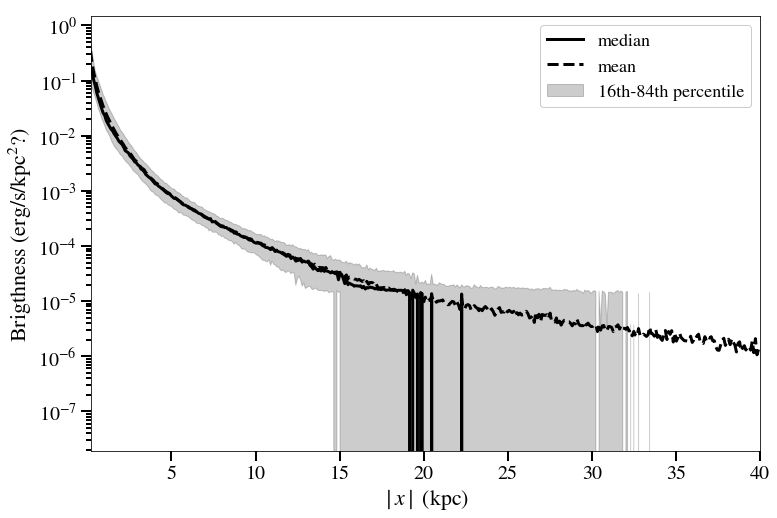

In [257]:

fig = plt.figure( figsize=(12, 8), facecolor='w' )
ax = plt.gca()

ax.plot(
    used_x_cents,
    median,
    linewidth = 3,
    color = 'k',
    linestyle = '-',
    label = 'median',
)

ax.plot(
    used_x_cents,
    mean,
    linewidth = 3,
    color = 'k',
    linestyle = '--',
    label = 'mean',
)

ax.fill_between(
    used_x_cents,
    lower,
    upper,
    color = 'k',
    alpha = 0.2,
    label = '16th-84th percentile',
)

# Kregel 2002
# ax.axvline(
#     r_kregel2002_in_hr * hr,
#     color = colormap[0],
#     linewidth = 3.,
#     label = r'Kregel+2002, $3.6h_{\rm R}$'
# )
# ax.fill_betweenx(
#     [ 0, 1 ],
#     [ ( r_kregel2002_in_hr - r_kregel2002_in_hr_std ) * hr, ]*2,
#     [ ( r_kregel2002_in_hr + r_kregel2002_in_hr_std ) * hr, ]*2,
#     color = colormap[0],
#     alpha = 0.2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
# )
# ax.axvline(
#     r_kregel2002_in_hr * hr_kravtsov2013_converted_kpc,
#     color = colormap[0],
#     linewidth = 3.,
#     linestyle = '--',
#     label = r'Kregel+2002, $3.6h_{\rm R,Kravtsov2013}$'
# )
# ax.fill_betweenx(
#     [ 0, 1 ],
#     [ ( r_kregel2002_in_hr - r_kregel2002_in_hr_std ) * hr_kravtsov2013_converted_kpc, ]*2,
#     [ ( r_kregel2002_in_hr + r_kregel2002_in_hr_std ) * hr_kravtsov2013_converted_kpc, ]*2,
#     color = colormap[0],
#     alpha = 0.2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
# )

# # Martin-Navarro 2012
# ax.axvline(
#     r_martinnavarro2012_kpc,
#     color = colormap[1],
#     linewidth = 3.,
#     label = r'Martin-Navarro+2012'
# )
# ax.fill_betweenx(
#     [ 0, 1 ],
#     [ r_martinnavarro2012_kpc - r_martinnavarro2012_kpc_std ]*2,
#     [ r_martinnavarro2012_kpc + r_martinnavarro2012_kpc_std ]*2,
#     color = colormap[1],
#     alpha = 0.2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
# )
# ax.axvline(
#     r_break_martinnavarro2012_kpc,
#     color = colormap[1],
#     linewidth = 3.,
#     label = r'Martin-Navarro+2012, $r_{\rm break}$',
#     linestyle = '--',
# )
# ax.fill_betweenx(
#     [ 0, 1 ],
#     [ r_break_martinnavarro2012_kpc - r_break_martinnavarro2012_kpc_std ]*2,
#     [ r_break_martinnavarro2012_kpc + r_break_martinnavarro2012_kpc_std ]*2,
#     color = colormap[1],
#     alpha = 0.2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
# )

# ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

ax.set_xlim( used_x_cents[0], 40. )
# ax.set_ylim( 1e-6, 1 )
# 
l = ax.legend( prop={'size': 18, }, framealpha=1.0 )

ax.set_xlabel( r'$\mid x \mid$ (kpc)', fontsize=22 )
ax.set_ylabel( r'Brigthness (erg/s/kpc$^2$?)', fontsize=22 )